In [32]:
import os
import sys
from pathlib import Path
from matplotlib.pyplot import imshow
import numpy as np
import torch
from scipy.ndimage import zoom
from scipy import ndimage
from model.MGUnet import MGUNet
from util import read_yml
from util.reader import reader
from scipy import ndimage
from albumentations import functional


cfg_path, img_folder, ckpath, out_dir, input_size = ["/yeping/new/AL-ACDC/EXP/ISIC_exp/SSL/0.03/Baseline/config.yml", "/yeping/new/AL-ACDC/data/ISIC/val/images/" ,"/yeping/new/AL-ACDC/EXP/ISIC_exp/SSL/0.03/Baseline/checkpoint/c0_best0.8198.pt", "/yeping/new/AL-ACDC/EXP/ISIC_exp/SSL/0.03/Baseline/inference/" ,"416"]
input_size = int(input_size)
assert os.path.exists(img_folder) and os.path.exists(ckpath)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

os.makedirs(out_dir, exist_ok=True)

cfg = read_yml(cfg_path)
model = MGUNet(cfg["Network"]).to(device)

model.load_state_dict(torch.load(ckpath, map_location=device)["model_state_dict"])
model.eval()

MGUNet(
  (acti_func): ReLU()
  (block1): UNetBlock(
    (acti_func): ReLU()
    (conv1): ConvolutionLayer(
      (acti_func): ReLU()
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (conv2): ConvolutionLayer(
      (acti_func): ReLU()
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
  )
  (block2): UNetBlock(
    (acti_func): ReLU()
    (conv1): ConvolutionLayer(
      (acti_func): ReLU()
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (conv2): ConvolutionLayer(
      (acti_func): ReLU()
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): Inst

In [4]:
def get_largest_k_components(image, k=1):
    """
    Get the largest K components from 2D or 3D binary image.

    :param image: The input ND array for binary segmentation.
    :param k: (int) The value of k.

    :return: An output array with only the largest K components of the input.
    """
    dim = len(image.shape)
    if (image.sum() == 0):
        print('the largest component is null')
        return image
    if (dim < 2 or dim > 3):
        raise ValueError("the dimension number should be 2 or 3")
    s = ndimage.generate_binary_structure(dim, 1)
    labeled_array, numpatches = ndimage.label(image, s)
    sizes = ndimage.sum(image, labeled_array, range(1, numpatches + 1))
    sizes_sort = sorted(sizes, reverse=True)
    kmin = min(k, numpatches)
    output = np.zeros_like(image)
    for i in range(kmin):
        labeli = np.where(sizes == sizes_sort[i])[0] + 1
        output = output + np.asarray(labeled_array == labeli, np.uint8)
    return output

In [5]:
g = "/yeping/new/AL-ACDC/data/ISIC/test/images/ISIC_0000001.npy"

In [35]:
img_npy = reader(g)().read_image(g)
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
img_npy = functional.normalize(img_npy,mean,std)
img_npy = np.ascontiguousarray(img_npy.transpose(2, 0, 1))[None]

*_, h, w = img_npy.shape

zoomed_img = zoom(img_npy, (1, 1, input_size / h, input_size / w), order=1,
                    mode='nearest')
zoomed_img = torch.from_numpy(zoomed_img).cuda()
output, _, _ = model(zoomed_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


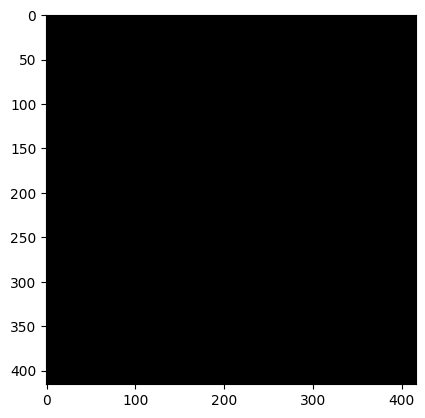

In [36]:
imshow(zoomed_img[0].permute(1,2,0).detach().cpu())

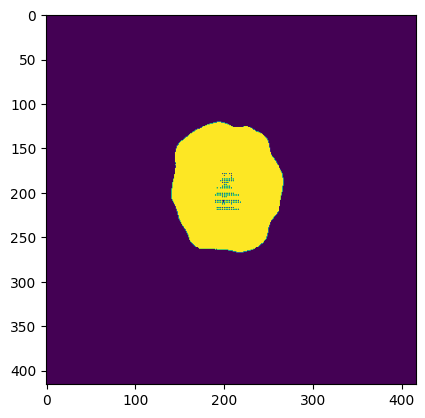

In [37]:
imshow(output[0].argmax(1).detach().cpu()[0])

In [8]:
batch_pred_mask = output[0].argmax(axis=1)[0].detach().cpu().numpy()
pred_volume = zoom(batch_pred_mask, (h / input_size, w / input_size), order=0,
                    mode='nearest')

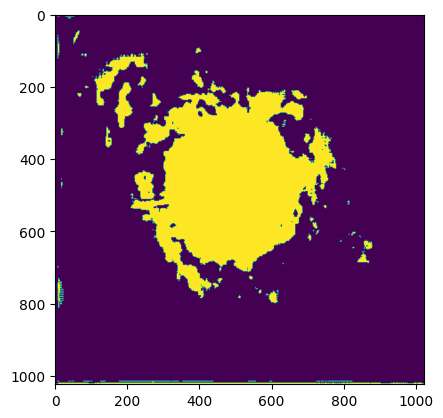

In [9]:
imshow(pred_volume)

In [10]:
batch_pred_mask.shape

(416, 416)

In [11]:
v = get_largest_k_components(batch_pred_mask)

In [12]:
v.shape

(416, 416)

In [13]:

s = ndimage.generate_binary_structure(2,1)
v = ndimage.binary_opening(v,s)
v = ndimage.binary_closing(v,s)

In [14]:
from matplotlib.pyplot import imshow

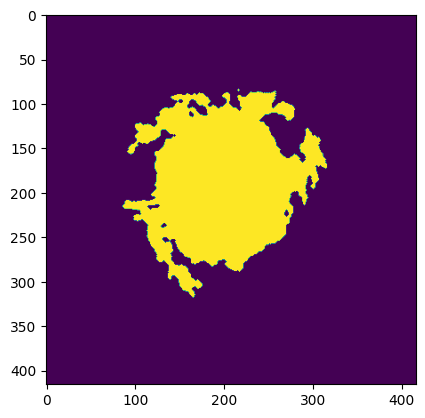

In [15]:
imshow(v
)

In [16]:
mask = np.load("/yeping/new/AL-ACDC/data/ISIC/test/mask/ISIC_0000001.npy")

In [17]:
m = zoom(mask,(416/1024,416/1024),order=0)

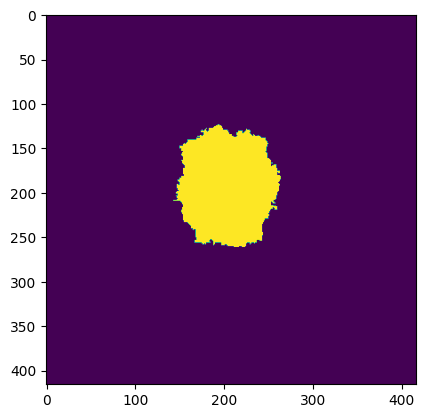

In [18]:
imshow(m)

In [10]:
import os
import os.path as osp
import numpy as np
from scipy.ndimage import zoom


In [7]:
target_dir = "/yeping/new/AL-ACDC/data/ISIC/test_size416"
source_dir = "/yeping/new/AL-ACDC/data/ISIC/test"

In [17]:
for  name in os.listdir(osp.join(source_dir, "mask")):
    img_path = osp.join(osp.join(source_dir, "images",name))
    mask_path = osp.join(osp.join(source_dir, "mask",name))
    i, g = np.load(img_path),np.load(mask_path)
    g = zoom(g, (416 / i.shape[0], 416 / i.shape[1]), order=0,
                          mode='nearest')
    i = zoom(i, (416 / i.shape[0], 416 / i.shape[1],1), order=1,
                          mode='nearest')
    target_img_path = osp.join(osp.join(target_dir, "images",name))
    target_mask_path = osp.join(osp.join(target_dir, "mask",name))
    np.save(target_img_path, i)
    np.save(target_mask_path, g)

In [22]:
from matplotlib.pyplot import  imshow

In [20]:
i,g = np.load("/yeping/new/AL-ACDC/data/ISIC/test_size416/images/ISIC_0000001.npy"),np.load("/yeping/new/AL-ACDC/data/ISIC/test_size416/mask/ISIC_0000001.npy")

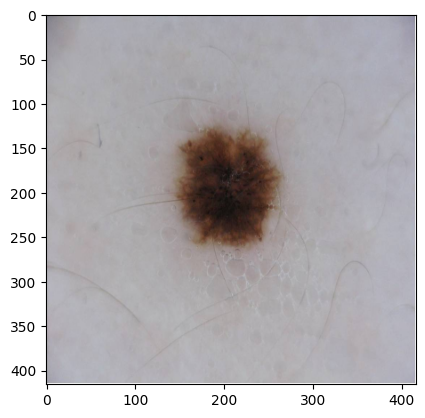

In [23]:
imshow(i)

In [3]:
imshow(g)

NameError: name 'g' is not defined

In [63]:
from torch.nn.functional import  pad,interpolate
import torch
import numpy as np
from matplotlib.pyplot import imshow
from torchvision.utils import make_grid

In [70]:
patch_size = 16
mask_ratio = 0.1
img = np.load('/home/yeep/project/py/deeplearning/AL-ACDC/data/ISIC/test/images/ISIC_0000017.npy')
device = "cuda"

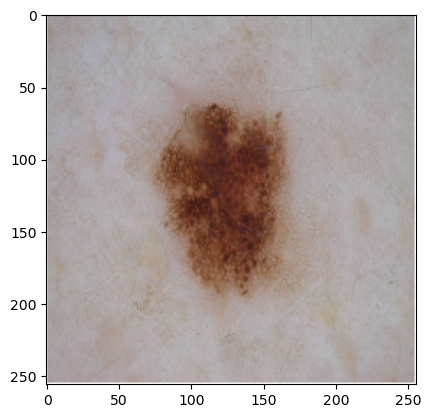

In [71]:
imshow(img)


In [72]:
img = torch.from_numpy(np.ascontiguousarray(img.transpose(2,0,1))).to(device)

In [73]:
img = img.permute(1,2,0)
h,w = img.shape[:2]

In [74]:
patched_data = torch.stack([p for f in torch.chunk(img, patch_size)
                   for p in torch.chunk(f, patch_size, dim=1)])

In [75]:
patch_num,c = patched_data.shape[0],patched_data.shape[-1]
num_patch_pixel = patch_size*patch_size
selected_idx = torch.randperm(patch_num)[:int(patch_num*mask_ratio)]
selected_patch = patched_data[selected_idx]
shuffled_patch = [p.view(num_patch_pixel,c)[torch.randperm(num_patch_pixel,device=device)].view(patch_size,patch_size,c)for p in selected_patch]
patched_data[selected_idx] = torch.stack(shuffled_patch)
shuffled_img = make_grid(patched_data.permute(0,3,1,2),nrow=h//patch_size,padding=0)

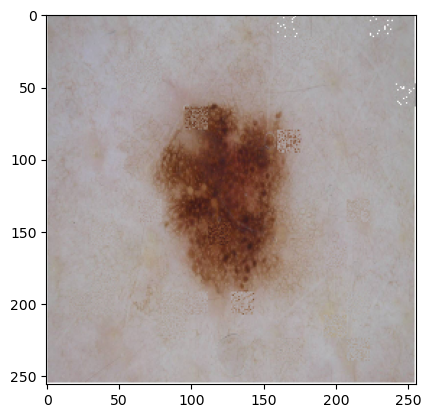

In [76]:
imshow(shuffled_img.permute(1,2,0).cpu())

In [17]:
patch_size = 16
mask_ratio = 0.1
img = np.load('/home/yeep/project/py/deeplearning/AL-ACDC/data/ISIC/test/images/ISIC_0000017.npy')
device = "cuda"


In [18]:
def local_shuffle()

In [47]:
shuffled_img = make_grid(data.permute(0,3,1,2),nrow=h//patch_size,padding=0)

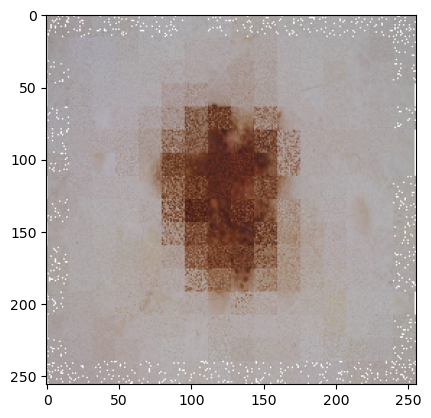

In [52]:
from sklearn.cluster import KMeans,MiniBatchKMeans
import numpy as np

In [53]:
a = np.random.randn(10,2)

In [54]:
a

array([[-1.83754795, -0.35757444],
       [-1.04387456,  0.23920131],
       [-1.15184841,  2.8237293 ],
       [-1.58570874, -0.75447441],
       [-1.65212568, -1.14102734],
       [ 0.52545692, -0.34521257],
       [-0.21888328, -0.68164708],
       [ 0.7911608 , -0.61854045],
       [-0.07402258,  0.14872773],
       [ 1.02046911, -0.29196548]])

In [55]:
cl = KMeans(n_clusters=8,n_init=100)

In [56]:
cl.fit(a)

KMeans(n_init=100)

In [60]:
cl.predict(a)

array([7, 4, 1, 2, 2, 6, 0, 6, 5, 3], dtype=int32)

In [61]:
np.argmin(cl.transform(a),axis=1)

array([7, 4, 1, 2, 2, 6, 0, 6, 5, 3])

In [10]:
from scipy.ndimage import binary_erosion,generate_binary_structure
from util import get_largest_k_components,label_smooth
def circus(mask):
    kernel = generate_binary_structure(2,1)
    return np.sum(mask - binary_erosion(mask, kernel))     

In [17]:
def circu_area_ratio(mask):
    labels = np.unique(mask)
    avg_cirarea = []
    for l in labels:
        if l == 0:
            continue
        c = mask == l
        area = np.sum(c)
        if area == 0:
            continue

        c = label_smooth(c[None])[0]
        componet = get_largest_k_components(c)
        if np.sum(componet) == 0:
            continue
        cir = circus(componet)
        avg_cirarea.append(cir/area)
        #越大不确定性越高
    return np.mean(avg_cirarea)

In [18]:
from pathlib import Path
import numpy as np

In [20]:
m = []
for p in Path("/home/yeep/project/py/deeplearning/AL-ACDC/data/ISIC/train/mask").iterdir():
    mask = np.load(p)
    m.append(circu_area_ratio(mask))

In [23]:
np.mean(m),np.std(m)

(0.047577274088761334, 0.031077461951975978)

In [24]:
np.random.uniform(0.04, 0.07)

0.042460993501361594